## Dependence of tracer scaling on initial curvature

In this notebook I explore the dependence of the gradient scaling near the rim to the initial curvature of the profile.
From what i saw in the notebook How_far_from_real_profiles.ipynb the scaling error $\sigma(\partial_zC)$ increased with increasing curvature.

Remember:

$\Phi_{Tr}=\Phi \bar{C}$

where $\frac{\Phi}{WUD_h} = 0.9\mathcal{F}_w^{3/2}R_o^{1/2}(1-1.21S_E)^3+0.07$, $\mathcal{F}_w=R_w/(0.9+R_w)$, $R_w=U/fW$, $S_E=sN/f(\mathcal{F}_w/R_o)^{1/2}$.

And, $\bar{C}$ is 
$\frac{\bar{C}}{C_0}= 0.04\frac{\partial_zC}{2} (H_s+H_r) + 1.0$

where
$\frac{\partial_zC}{\partial_zC_0}= 6.3\frac{Z+Z_{dif}}{H_s}+1.0$

and 

$Z_{dif}=(t(\kappa_{can}-\kappa_{bg}))^{1/2}$


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from netCDF4 import Dataset
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Constants and scales

# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3
f = 9.66E-5
kv = 1E-5
kbg = 1E-5
t = 6 # days
U = 0.35 # m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_file_parab = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run01/ptracersGlob.nc'

ptracers_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

time = state.variables['T']
depth = grid.variables['RC']

In [5]:
fileBAR = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/HCW_TrMass_CNTDIFF_LOW_SR_7Tr_run01.csv')
fileLWRNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/HCW_TrMass_CNTDIFF_LOW_SR_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [6]:
import canyon_records_tracers
records = canyon_records_tracers.main()

In [7]:
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['tan','0.2','0.3','0.4','0.5','0.6','0.7'] 
sizes_Para = [11,7,7,7,7,7,7] 


### Profiles, gradients and curvatures

-0.00410011291504
-0.0334272003174
4.16559799194
-0.875917987823
-0.995187606812
-0.00442902088165
-0.232606830597
-0.358671226501
-0.106219673157
-0.162045822144
-0.157568216324
-0.124052467346
-0.204130589962
0.713711147308
-0.952072753906


(-180, -100)

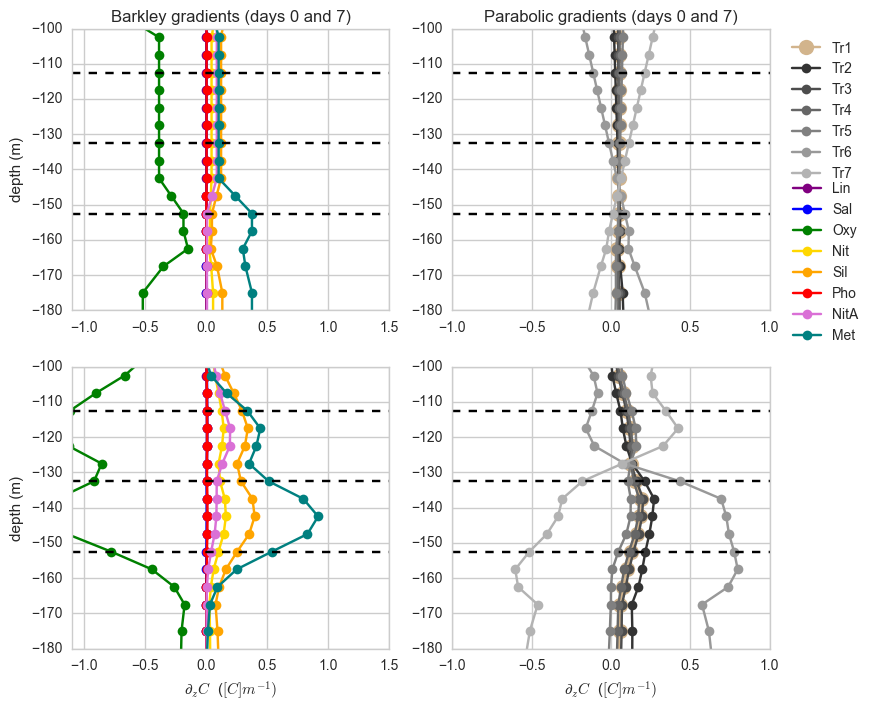

In [8]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,8))

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_dTrdz = np.empty(8)
Bar_inidTrdz = np.empty(8)
Bar_dTrdz_std = np.empty(8)
       
Par_dTrdz = np.empty(7)
Par_inidTrdz = np.empty(7)
Par_dTrdz_std = np.empty(8)

record = records[0]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Bark, labels_Bark):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = (df_anom[keys[0]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd4 = (df_anom[keys[1]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd5 = (df_anom[keys[2]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd6 = (df_anom[keys[3]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd7 = (df_anom[keys[4]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
 
    ax1.plot(-df[key0][:],depth[1:-1],'o-',color=col,label=lab)
    ax3.plot(-df[keys[3]][:],depth[1:-1],'-o',color=col,label=lab)
    
    Bar_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    print(Bar_dTrdz[ii])
    Bar_inidTrdz[ii] = df[key0][30]
    Bar_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    ii = ii+1
    
record = records[1]
ii = 0
for tracer,col,lab,ms in zip(record.tracerList, colours_Para, labels_Para, sizes_Para):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
 
    
    maxd3 = (df_anom[keys[0]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd4 = (df_anom[keys[1]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd5 = (df_anom[keys[2]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd6 = (df_anom[keys[3]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
    maxd7 = (df_anom[keys[4]][np.argmax(np.abs(np.array(df[key0][22:30])))+22])   
 
    ax2.plot(-df[key0][:],depth[1:-1],'o-',markersize=ms, color=col,label=lab)
    ax4.plot(-df[keys[3]][:],depth[1:-1],'o-',markersize=ms,color=col,label=lab)
    
    Par_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    print(Par_dTrdz[ii])
    Par_inidTrdz[ii] = df[key0][30]
    Par_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
   
    ii = ii+1
    
ax3.set_xlabel('$\partial_z{C}$  ($[C]m^{-1})$')
ax3.set_ylabel('depth (m)')
ax1.set_ylabel('depth (m)')
ax1.set_title('Barkley gradients (days 0 and 7)')

ax4.set_xlabel('$\partial_z{C}$  ($[C]m^{-1})$')
ax2.set_title('Parabolic gradients (days 0 and 7)')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax1.legend(bbox_to_anchor=(2.52,0.5),ncol=1, columnspacing=0.1)

ax2.axhline(depth[22],linestyle='--',color='k')
ax1.axhline(depth[22],linestyle='--',color='k')
ax2.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[30],linestyle='--',color='k')
ax2.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[22],linestyle='--',color='k')
ax3.axhline(depth[22],linestyle='--',color='k')
ax4.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[30],linestyle='--',color='k')

ax1.set_xlim(-1.1,1.5)
ax1.set_ylim(-180,-100)
ax2.set_xlim(-1,1)
ax2.set_ylim(-180,-100)
ax3.set_xlim(-1.1,1.5)
ax3.set_ylim(-180,-100)
ax4.set_xlim(-1,1)
ax4.set_ylim(-180,-100)

(-180, -100)

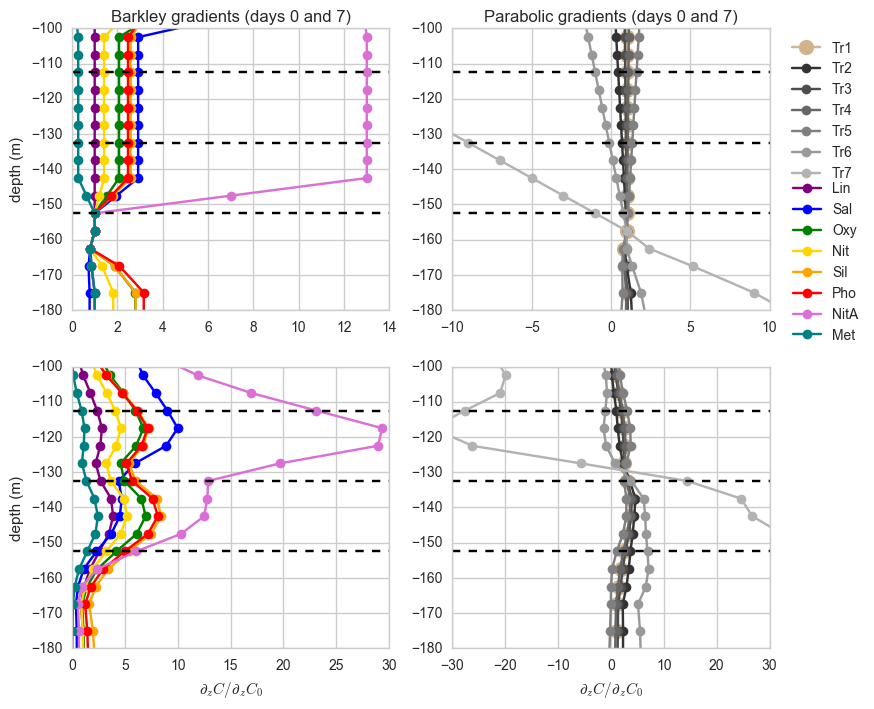

In [9]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,8))

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

record = records[0]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Bark, labels_Bark):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    ax1.plot(-df[key0][:]/-df[key0][30],depth[1:-1],'o-',color=col,label=lab)
    ax3.plot(-df[keys[3]][:]/-df[key0][30],depth[1:-1],'-o',color=col,label=lab)
    
    ii = ii+1
    
record = records[1]
ii = 0
for tracer,col,lab,ms in zip(record.tracerList, colours_Para, labels_Para, sizes_Para):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    ax2.plot(-df[key0][:]/-df[key0][30],depth[1:-1],'o-',markersize=ms, color=col,label=lab)
    ax4.plot(-df[keys[3]][:]/-df[key0][30],depth[1:-1],'o-',markersize=ms,color=col,label=lab)
    
    ii = ii+1
    
ax3.set_xlabel('$\partial_z{C}/\partial_z{C}_0$') 
ax3.set_ylabel('depth (m)')
ax1.set_ylabel('depth (m)')
ax1.set_title('Barkley gradients (days 0 and 7)')

ax4.set_xlabel('$\partial_z{C}/\partial_z{C}_0$')
ax2.set_title('Parabolic gradients (days 0 and 7)')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax1.legend(bbox_to_anchor=(2.52,0.5),ncol=1, columnspacing=0.1)

ax2.axhline(depth[22],linestyle='--',color='k')
ax1.axhline(depth[22],linestyle='--',color='k')
ax2.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[30],linestyle='--',color='k')
ax2.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[22],linestyle='--',color='k')
ax3.axhline(depth[22],linestyle='--',color='k')
ax4.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[30],linestyle='--',color='k')

ax1.set_xlim(0,14)
ax1.set_ylim(-180,-100)
ax2.set_xlim(-10,10)
ax2.set_ylim(-180,-100)
ax3.set_xlim(-0,30)
ax3.set_ylim(-180,-100)
ax4.set_xlim(-30,30)
ax4.set_ylim(-180,-100)

(-180, -100)

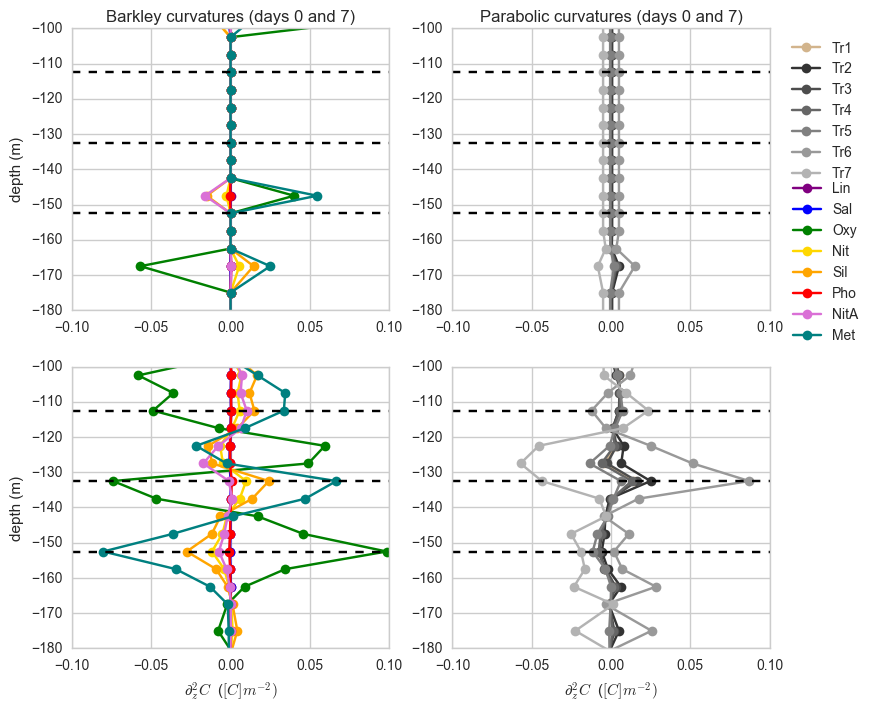

In [10]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,8))

keys = ['dTr2dz2_tt08','dTr2dz2_tt10','dTr2dz2_tt12','dTr2dz2_tt14','dTr2dz2_tt16']
key0 = 'dTr2dz2_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_inidTr2dz2 = np.empty(8)
Bar_max_curv = np.empty(8)
Bar_max_curv_sb = np.empty(8)
       
Par_inidTr2dz2 = np.empty(7)
Par_max_curv = np.empty(8)
Par_max_curv_sb = np.empty(8)

record = records[0]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Bark, labels_Bark):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr2dz2_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    ax1.plot(df[key0][:],depth[1:-1],'o-',color=col,label=lab)
    ax3.plot(df[keys[3]][:],depth[1:-1],'-o',color=col,label=lab)
    
    max_ind = np.argmax(np.abs(np.array(df[key0][22:30])))
    Bar_max_curv[ii] = (df[key0][max_ind+22])
    Bar_max_curv_sb[ii] = np.max(np.abs(np.array(df[key0][30:36])))
    Bar_inidTr2dz2[ii] = df[key0][30]
    
    ii = ii+1
    
record = records[1]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Para, labels_Para):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr2dz2_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    ax2.plot(df[key0][:],depth[1:-1],'o-',color=col,label=lab)
    ax4.plot(df[keys[3]][:],depth[1:-1],'o-',color=col,label=lab)
    
    max_ind = np.argmax(np.abs(np.array(df[key0][22:30])))
    Par_max_curv[ii] = (df[key0][max_ind+22])
    Par_max_curv_sb[ii] = np.max(np.abs(np.array(df[key0][30:36])))

    ii = ii+1
    
ax3.set_xlabel('$\partial_z^2{C}$  ($[C]m^{-2})$')
ax3.set_ylabel('depth (m)')
ax1.set_ylabel('depth (m)')
ax1.set_title('Barkley curvatures (days 0 and 7)')

ax4.set_xlabel('$\partial_z^2{C}$  ($[C]m^{-2})$')
ax2.set_title('Parabolic curvatures (days 0 and 7)')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax1.legend(bbox_to_anchor=(2.52,0.5),ncol=1, columnspacing=0.1)

ax2.axhline(depth[22],linestyle='--',color='k')
ax1.axhline(depth[22],linestyle='--',color='k')
ax2.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[26],linestyle='--',color='k')
ax1.axhline(depth[30],linestyle='--',color='k')
ax2.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[22],linestyle='--',color='k')
ax3.axhline(depth[22],linestyle='--',color='k')
ax4.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[26],linestyle='--',color='k')
ax3.axhline(depth[30],linestyle='--',color='k')
ax4.axhline(depth[30],linestyle='--',color='k')

ax1.set_xlim(-0.1,0.1)
ax1.set_ylim(-180,-100)
ax2.set_xlim(-0.1,0.1)
ax2.set_ylim(-180,-100)
ax3.set_xlim(-0.1,0.1)
ax3.set_ylim(-180,-100)
ax4.set_xlim(-0.1,0.1)
ax4.set_ylim(-180,-100)

In [11]:
# get metrics
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_maxTr = np.empty(8)
Bar_stdTr = np.empty(8)
Bar_TrSB = np.empty(8)
Bar_Ctop = np.empty(8)

Par_maxTr = np.empty(7)
Par_stdTr = np.empty(7)
Par_TrSB = np.empty(7)
Par_Ctop = np.empty(7)

record = records[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
    
    
    Bar_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_TrSB[ii] = maxd0
    Bar_Ctop[ii] = df[key0][0]
    ii=ii+1
    
record = records[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
   
    
    Par_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_TrSB[ii] = maxd0
    Par_Ctop[ii] = df[key0][0]
    ii=ii+1


In [12]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']



In [13]:
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/No
Zdif = np.sqrt(t*3600*24*(kv-kbg))
    
Se = (s*No)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
HA2013=(U*W*Dh(f,L,No))*((0.91*(F(Ro(U,f,W))**(3/2))*(Ro(U,f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

## Effect of curvature

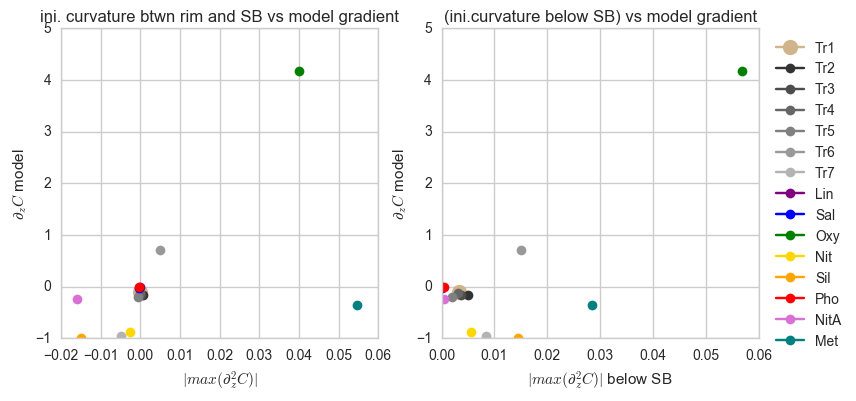

In [19]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for dTrMod, dTr0, Curv, CurvSB, lab, col, ms in zip(Par_dTrdz,Par_inidTrdz,Par_max_curv,Par_max_curv_sb,
                                              labels_Para,colours_Para,sizes_Para):
    
    ax1.plot(Curv,dTrMod,  color=col, label=lab, marker='o', markersize=ms)
    ax2.plot(CurvSB, dTrMod,  color=col, label=lab, marker='o', markersize=ms)
    
for dTrMod, dTr0, Curv, CurvSB, lab, col in zip(Bar_dTrdz, Bar_inidTrdz, Bar_max_curv, Bar_max_curv_sb, 
                                          labels_Bark,colours_Bark):
    
    ax1.plot(Curv, dTrMod,  color=col, label=lab, marker='o')
    ax2.plot(CurvSB, dTrMod,  color=col, label=lab, marker='o')
       
ax1.set_xlabel(r'$|max(\partial_z^2C)|$')
ax1.set_ylabel('$\partial_zC$ model')
ax1.set_title('ini. curvature btwn rim and SB vs model gradient')

#ax1.set_ylim(0,80)
#ax1.set_xlim(-0.15,0.05)
#ax1.plot(np.linspace(-1.5,1.5,100),np.linspace(-1.5,1.5,100),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$|max(\partial_z^2C)|$ below SB')
ax2.set_ylabel(r'$\partial_zC$ model')
ax2.set_title(r'(ini.curvature below SB) vs model gradient')
#ax2.set_ylim(0,80)
#ax2.set_xlim(-0.15,0.05)
#ax2.plot(np.linspace(0,150,100),np.linspace(0,150,100),'-k')


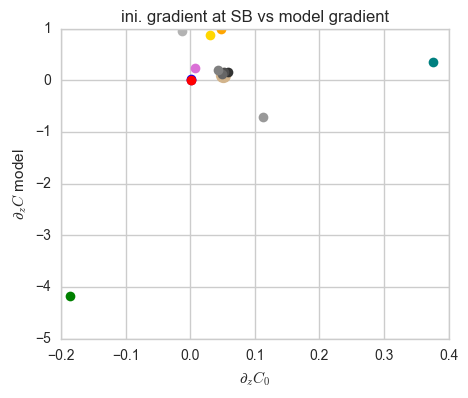

In [15]:
fig,ax1 = plt.subplots(1,1,figsize=(5,4))

rec = records[0]

for dTrMod, iniTr, lab, col, ms in zip(Par_dTrdz,Par_inidTrdz,
                                              labels_Para,colours_Para,sizes_Para):
    
    ax1.plot(-iniTr,-dTrMod,  color=col, label=lab, marker='o', markersize=ms)
    
for dTrMod, iniTr, lab, col in zip(Bar_dTrdz, Bar_inidTrdz, 
                                          labels_Bark,colours_Bark):
    
    ax1.plot(-iniTr, -dTrMod,  color=col, label=lab, marker='o')
       
ax1.set_xlabel(r'$ \partial_z C_0$')
ax1.set_ylabel('$\partial_zC$ model')
ax1.set_title('ini. gradient at SB vs model gradient')

#ax1.set_ylim(0,80)
#ax1.set_xlim(-0.15,0.05)
#ax1.plot(np.linspace(-1.5,1.5,100),np.linspace(-1.5,1.5,100),'-k')

